## Importing Required Libraries

In [3]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Analysis of Labelled and Unlabelled Data

In [4]:
# Unlabelled Data
unlabelled=pd.read_csv('/content/drive/MyDrive/datasets/unlabelled_data.csv')

In [5]:
unlabelled

,Unnamed: 0,doc_id,text,country,year
0,0,ARG_25_1970.txt.1,177.\t : It is a fortunate coincidence that pr...,ARG,1970
1,1,ARG_25_1970.txt.2,"On behalf of the Argentine Government, it is a...",ARG,1970
2,2,ARG_25_1970.txt.3,178.,ARG,1970
3,3,ARG_25_1970.txt.4,Through you I should also like to express the ...,ARG,1970
4,4,ARG_25_1970.txt.5,179.,ARG,1970
...,...,...,...,...,...
2041695,2041695,ZWE_75_2020.txt.63,Ladies and Gentlemen.,ZWE,2020
2041696,2041696,ZWE_75_2020.txt.64,Let me conclude by reaffirming Zimbabwe’s comm...,ZWE,2020
2041697,2041697,ZWE_75_2020.txt.65,There is no better way of achieving a peaceful...,ZWE,2020
2041698,2041698,ZWE_75_2020.txt.66,Recommitting ourselves to these ideals will pa...,ZWE,2020


In [6]:
# Labelled Data
labelled=pd.read_csv('/content/labelled_data.csv')
labelled

,Unnamed: 0,doc_id,text,country,year,coding,difficult
0,AUS_46_1991.txt.1,AUS_46_1991.txt.1,"I congratulate you, Sir, on your election as P...",AUS,1991,greeting,0.0
1,AUS_46_1991.txt.2,AUS_46_1991.txt.2,I am sure we will all benefit from your long e...,AUS,1991,greeting,0.0
2,AUS_46_1991.txt.3,AUS_46_1991.txt.3,Australia enjoys strong bonds of friendship wi...,AUS,1991,greeting,0.0
3,AUS_46_1991.txt.4,AUS_46_1991.txt.4,Australia warmly welcomes to membership of thi...,AUS,1991,greeting,0.0
4,AUS_46_1991.txt.5,AUS_46_1991.txt.5,"Equally, as a country of the Asia-Pacific regi...",AUS,1991,greeting,0.0
...,...,...,...,...,...,...,...
2645,EST_72_2017.txt.92,EST_72_2017.txt.92,"As a small country, we care for all those who ...",EST,2017,security,0.0
2646,EST_72_2017.txt.93,EST_72_2017.txt.93,"As a digital society, we are a story of hope a...",EST,2017,development,0.0
2647,EST_72_2017.txt.94,EST_72_2017.txt.94,"Again, as a digital State, we consider transpa...",EST,2017,human,0.0
2648,EST_72_2017.txt.95,EST_72_2017.txt.95,We are adamant supporters of rules-based decis...,EST,2017,democracy,0.0


In [7]:
# Removing labelled senteces from unlabelled dataset

mask = unlabelled['country'].isin(labelled['country']) & unlabelled['year'].isin(labelled['year']) & unlabelled['doc_id'].isin(labelled['doc_id'])
final_unlabelled = unlabelled[~mask]
final_unlabelled

,Unnamed: 0,doc_id,text,country,year
0,0,ARG_25_1970.txt.1,177.\t : It is a fortunate coincidence that pr...,ARG,1970
1,1,ARG_25_1970.txt.2,"On behalf of the Argentine Government, it is a...",ARG,1970
2,2,ARG_25_1970.txt.3,178.,ARG,1970
3,3,ARG_25_1970.txt.4,Through you I should also like to express the ...,ARG,1970
4,4,ARG_25_1970.txt.5,179.,ARG,1970
...,...,...,...,...,...
2041695,2041695,ZWE_75_2020.txt.63,Ladies and Gentlemen.,ZWE,2020
2041696,2041696,ZWE_75_2020.txt.64,Let me conclude by reaffirming Zimbabwe’s comm...,ZWE,2020
2041697,2041697,ZWE_75_2020.txt.65,There is no better way of achieving a peaceful...,ZWE,2020
2041698,2041698,ZWE_75_2020.txt.66,Recommitting ourselves to these ideals will pa...,ZWE,2020


### Analysis of labels

1. Distribution of labels


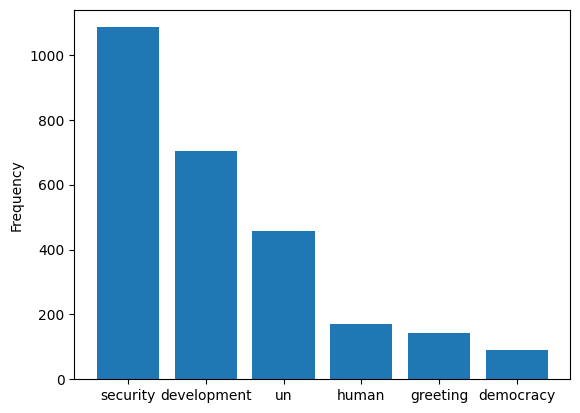

In [8]:
freq = labelled['coding'].value_counts()
plt.bar(freq.index, freq.values)
plt.ylabel('Frequency')
plt.show()

### Preprocessing

1. Remove stopwords (the, a , an...).
2. Remove punctuation (:, , ., ?...).
3. Remove Numbers (1, 199, 12)
4. Remove whitespaces.
5. Converting words into lowercase
6. Tokenization (sentence -> list of words)

In [9]:
def load_sentences(data, type='train'):
  
  '''
    Extracts features and labels from dataset

  '''
  
  sentences, labels = [], []
  sentences = list(data['text'])

  if type == 'train':
    labels = list(data['coding'])
  sentences = [sentence.split('\t') for sentence in sentences]

  return sentences, labels

In [10]:
# Labelled Data
sentences, lables = load_sentences(labelled, 'train')

print('Training Sentences: ',len(sentences))
print('Training Labels: ',len(lables))
print('Training Example: ',sentences[0])

# Unlabelled Data
test_sentences, _ = load_sentences(final_unlabelled, 'test')

print('Testing Sentences: ',len(test_sentences))
print('Testing Example: ',test_sentences[16])

Training Sentences:  2650
Training Labels:  2650
Training Example:  ['I congratulate you, Sir, on your election as President of the forty-sixth session of the General Assembly.']
Testing Sentences:  2039133
Testing Example:  ['The so-called "European concert" is good proof of this concept which restricted the active access of the nonEuropean states to international life.']


### **Functions**

##### Preprocessor class

1. Removes punctuations, numbers, whitespaces
2. Converts sentences into lower case

##### remove_stopword function

1. Removes Stopwords
2. Tokenizes Sentences

##### empty_sentences function

1. Removes the sentences with less than 2 words

In [11]:
class Preprocessor:
  '''
    Removes punctuations, numbers, whitespaces
    Converts sentences into lower case
  '''
  def __init__(self, numbers=True, punct=True):
    self.numbers = numbers
    self.punct = punct

  def apply(self, sentence):
    sentence = sentence.lower()
    if self.numbers:
      sentence = Preprocessor.remove_numbers(sentence)
    if self.punct: 
      sentence = Preprocessor.remove_punct(sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence
  
  @staticmethod
  def remove_punct(sentence):
    sentence = re.sub(r'[^\w\s]', '', sentence)
    return sentence
  
  @staticmethod
  def remove_numbers(sentence):
    sentence = re.sub(r'[0-9]', '', sentence)
    return sentence

In [12]:
# Example of preprocessor class
print('Before: ', sentences[0][0])
processor = Preprocessor()
print('After: ', processor.apply(sentences[0][0]))

Before:  I congratulate you, Sir, on your election as President of the forty-sixth session of the General Assembly.
After:  i congratulate you sir on your election as president of the fortysixth session of the general assembly


In [13]:
def remove_stopwords(data):
  '''
    Removes Stopwords
    Tokenizes Sentences
    
  '''
  sentences = []
  split_sent = data.split()
  stopwords_set = set(stopwords.words('english'))
  sentences = [word for word in split_sent if word.lower() not in stopwords_set]
  return sentences

In [14]:
# Example of Removing stopwords and Tokenization
print('Before: ', sentences[0][0])
print('After: ', remove_stopwords(sentences[0][0]))

Before:  I congratulate you, Sir, on your election as President of the forty-sixth session of the General Assembly.
After:  ['congratulate', 'you,', 'Sir,', 'election', 'President', 'forty-sixth', 'session', 'General', 'Assembly.']


In [15]:
processor = Preprocessor()

# Labelled Data
clean_sentences = []
for idx, sentence in tqdm(enumerate(sentences)):
  clean_sentence = processor.apply(sentence[0])
  clean_sentences.append(remove_stopwords(clean_sentence))


# Unlabelled data
test_clean_sentences = []
for idx, sentence in tqdm(enumerate(test_sentences)):
  clean_sentence = processor.apply(sentence[0])
  test_clean_sentences.append(remove_stopwords(clean_sentence))

2650it [00:00, 6121.39it/s]
2039133it [05:29, 6189.41it/s]


In [16]:
print('Example of a cleaned sentence')
print(clean_sentences[0])

Example of a cleaned sentence
['congratulate', 'sir', 'election', 'president', 'fortysixth', 'session', 'general', 'assembly']


In [17]:
# checking for empty sentences
def empty_sentences(data):
  
  '''
    Removes the sentences with less than 2 words
  '''
  print('Length before', len(data))

  sentences = [sublist for sublist in data if not all(elem == "" for elem in sublist)]
  train_sentences = []
  indices = []
  removed_sentences = []
  for idx, sentence in enumerate(sentences):
    if len(sentence) <= 2:
      indices.append(idx)
      removed_sentences.append(sentence)
    else:
      train_sentences.append(sentence)
  print('Length after', len(train_sentences))
  
  return train_sentences, indices, removed_sentences

In [18]:
# Labelled Data
print("Labelled data")
train_sentences, indices, removed_sentences = empty_sentences(clean_sentences)

print()

# Unlabelled data
print("unlabelled data")
test_sentences, test_indices, removed_test_sentences = empty_sentences(test_clean_sentences)

Labelled data
Length before 2650
Length after 2604

unlabelled data
Length before 2039133
Length after 1589306


### **Encoding**

-- BERT

In [19]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from transformers import BertTokenizer, BertModel

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [22]:
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
#
corpus_tokens = [tokenizer.encode(sent, add_special_tokens=True) for sent in train_sentences]

In [24]:
#
max_len = max([len(seq) for seq in corpus_tokens])
padded_corpus = [seq + [0]*(max_len-len(seq)) for seq in corpus_tokens]

In [25]:
import torch 

padded_corpus = torch.LongTensor(padded_corpus)

In [26]:
with torch.no_grad():
    encoded_vectors = model(padded_corpus[:10])[0]

In [28]:
len(encoded_vectors)

10

In [46]:
len(encoded_vectors[9])

75